# Trading Notebook
J Daniel Kim

Overall goal: Recently, there has been a rise of retail traders in the market. The purpose of this project is to create a easy to use equity trading service that helps take emotional decisions out of the factor. Also, I want to discover if my model could profit in the  2020.


MVP Goal:Fit baseline models such as ARIMA and VARIMAX.  Move onto fitting simple neural networks and LSTM's

Evaluation metrics: Accuracy,RMSE, MSE, MAE

In [1]:
#importing packages
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import requests
import pmdarima as pm
from statsmodels.tsa.api import VAR
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
#Transforming income dataset
def Income_statement(df):
    df = df.T
    header = df.iloc[0]
    df.columns=header
    df.reset_index(inplace=True)
    df = df[2:]
    df['index'] = pd.to_datetime(df['index'],format = '%m/%d/%Y')
    df.set_index('index',inplace=True)
    columns=['EBIT', 'TotalRevenue','\tNetIncome']
    for i in columns:
        df[i] = df[i].str.replace(',', '')
    df = df[['EBIT', 'TotalRevenue','\tNetIncome']].astype(float)
    df.rename(columns={'\tNetIncome':'NetIncome'},inplace=True)
    return df.resample('D').ffill()['2005-01-01':]
    

In [3]:
#Transforming cashflow dataset
def cashflow_organize(df):
    df = df.T
    header = df.iloc[0]
    df.columns=header
    df.reset_index(inplace=True)
    df = df[2:]
    df['index'] = pd.to_datetime(df['index'],format = '%m/%d/%Y')
    df.set_index('index',inplace=True)
    columns=['FreeCashFlow','FinancingCashFlow','InvestingCashFlow','OperatingCashFlow']
    for i in columns:
        df[i] = df[i].str.replace(',', '')
    df = df[['FreeCashFlow','FinancingCashFlow','InvestingCashFlow','OperatingCashFlow']].astype(float)
    return df.resample('D').ffill()['2005-01-01':]

In [4]:
#Transforming financials
def cleaning_valuation(df):
    df = df.T
    header = df.iloc[0]
    df.columns=header
    df.reset_index(inplace=True)
    df = df[2:]
    df['index'] = pd.to_datetime(df['index'],format = '%m/%d/%Y')
    df.set_index('index',inplace=True)
    columns = ['MarketCap', 'PeRatio']
    changing = ['MarketCap',  'PeRatio']
    df.drop(columns=['EnterpriseValue','EnterprisesValueRevenueRatio','EnterprisesValueEBITDARatio','PsRatio', 'PbRatio', 'ForwardPeRatio', 'PegRatio'],inplace=True)
    for i in columns:
        df[i] = df[i].str.replace(',', '')
    for j in changing:
        df[j] = df[j].map(lambda x: float(x))
    return df.resample('D').ffill()['2005-01-01':]
    
        

In [5]:
#Transforming financials
def cleaning_valuation2(df):
    df = df.T
    header = df.iloc[0]
    df.columns=header
    df.reset_index(inplace=True)
    df = df[2:]
    df['index'] = pd.to_datetime(df['index'],format = '%m/%d/%Y')
    df.set_index('index',inplace=True)
    columns = ['MarketCap','PeRatio']
    changing = ['MarketCap', 'PeRatio']
    df.drop(columns=['EnterpriseValue', 'EnterprisesValueRevenueRatio','PsRatio', 'PbRatio', 'ForwardPeRatio', 'PegRatio'],inplace=True)
    for i in columns:
        df[i] = df[i].str.replace(',', '')
    for j in changing:
        df[j] = df[j].map(lambda x: float(x))
    return df.resample('D').ffill()['2005-01-01':]
    
        

In [6]:
#Transforming financials
def cleaning_valuation3(df):
    df = df.T
    header = df.iloc[0]
    df.columns=header
    df.reset_index(inplace=True)
    df = df[2:]
    df['index'] = pd.to_datetime(df['index'],format = '%m/%d/%Y')
    df.set_index('index',inplace=True)
    columns = ['MarketCap','PeRatio']
    changing = ['MarketCap', 'PeRatio']
    df.drop(columns=['PsRatio', 'PbRatio', 'ForwardPeRatio', 'PegRatio'],inplace=True)
    for i in columns:
        df[i] = df[i].str.replace(',', '')
    for j in changing:
        df[j] = df[j].map(lambda x: float(x))
    return df.resample('D').ffill()['2005-01-01':]
    
        

In [7]:
#Helping rename columns
def column_names(x):
    x.rename(columns={0:'Open', 1:'High', 2:'Low', 3:'Close', 4:'Volume', 5:'Dividends', 6:'MarketCap',
       7:'PeRatio', 8:'EBIT', 9:'TotalRevenue', 10:'NetIncome', 11:'FreeCashFlow',
       12:'FinancingCashFlow', 13:'InvestingCashFlow', 14:'OperatingCashFlow', 15:'mean'},inplace=True)
    return x

In [8]:
#Importing and scaling vix data
vix = pd.read_csv('vixcurrent.csv',header=1)
vix['mean'] = (vix['VIX High'] + vix['VIX Low'])/2
vix['Date'] = pd.to_datetime(vix['Date'], format="%m/%d/%Y")
vix.set_index('Date',inplace=True)
vix['mean']=vix['mean'].map(lambda x:-x)
vix = vix.ffill()
vix_mean = pd.DataFrame(vix['mean'])['2005-01-01':]

In [387]:
#Microsoft
MSFT_valuation = cleaning_valuation(pd.read_csv('MSFT/MSFT_monthly_valuation_measures.csv'))
MSFT_income_statement = Income_statement(pd.read_csv('MSFT/MSFT_quarterly_financials.csv'))
MSFT_cashflow = cashflow_organize(pd.read_csv('MSFT/MSFT_quarterly_cash-flow.csv'))
#APPLE
AAPL_valuation = cleaning_valuation(pd.read_csv('AAPL/AAPL_monthly_valuation_measures.csv'))
AAPL_cashflow = cashflow_organize(pd.read_csv('AAPL/AAPL_quarterly_cash-flow.csv'))
AAPL_income_statement = Income_statement(pd.read_csv('MSFT/MSFT_quarterly_financials.csv'))

#Amazon does not have dividends
AMZN_valuation = cleaning_valuation(pd.read_csv('AMZN/AMZN_monthly_valuation_measures.csv'))
AMZN_cashflow = cashflow_organize(pd.read_csv('AMZN/AMZN_quarterly_cash-flow.csv'))
AMZN_income_statement = Income_statement(pd.read_csv('AMZN/AMZN_quarterly_financials.csv'))

#JNJ
JNJ_valuation = cleaning_valuation(pd.read_csv('JNJ/JNJ_monthly_valuation_measures.csv'))
JNJ_cashflow = cashflow_organize(pd.read_csv('JNJ/JNJ_quarterly_cash-flow.csv'))
JNJ_income_statement = Income_statement(pd.read_csv('JNJ/JNJ_quarterly_financials.csv'))

#Visacard
# V_valuation = cleaning_valuation(pd.read_csv('V/V_monthly_valuation_measures.csv'))
# V_cashflow = cashflow_organize(pd.read_csv('V/V_quarterly_cash-flow.csv'))
# V_income_statement = Income_statement(pd.read_csv('V/V_quarterly_financials.csv'))

#Facebook does not have dividends
# FB_valuation = cleaning_valuation(pd.read_csv('FB/FB_monthly_valuation_measures.csv'))
# FB_cashflow = cashflow_organize(pd.read_csv('FB/FB_quarterly_cash-flow.csv'))
# FB_income_statement = Income_statement(pd.read_csv('FB/FB_quarterly_financials.csv'))

#Berkshire Hathway does not have dividends 
BRK_B_valuation = cleaning_valuation2(pd.read_csv('BRK-B/BRK-B_monthly_valuation_measures.csv'))
BRK_B_cashflow = cashflow_organize(pd.read_csv('BRK-B/BRK-B_quarterly_cash-flow.csv'))
BRK_B_income_statement = Income_statement(pd.read_csv('BRK-B/BRK-B_quarterly_financials.csv'))

#Berkshire Hathway does not have dividends
GOOGL_valuation = cleaning_valuation(pd.read_csv('GOOGL/GOOGL_monthly_valuation_measures.csv'))
GOOGL_cashflow = cashflow_organize(pd.read_csv('GOOGL/GOOGL_quarterly_cash-flow.csv'))
GOOGL_income_statement = Income_statement(pd.read_csv('GOOGL/GOOGL_quarterly_financials.csv'))

#JP Morgan
JPM_valuation = cleaning_valuation3(pd.read_csv('JPM/JPM_monthly_valuation_measures.csv'))
JPM_cashflow = cashflow_organize(pd.read_csv('JPM/JP_quarterly_cash-flow.csv'))
JPM_income_statement = Income_statement(pd.read_csv('JPM/JP_quarterly_financials.csv'))

#Proctor and gamble 
PG_valuation = cleaning_valuation(pd.read_csv('PG/PG_monthly_valuation_measures.csv'))
PG_cashflow = cashflow_organize(pd.read_csv('PG/PG_quarterly_cash-flow.csv'))
PG_income_statement = Income_statement(pd.read_csv('PG/PG_quarterly_financials.csv'))


In [388]:
#Transforming stock data
def yfinance_import(x):
    stock = yf.Ticker(x)
    hist = stock.history(period='max')
    hist.reset_index(inplace=True)
    hist['Date'] = pd.to_datetime(hist['Date'])
    hist.set_index('Date',inplace=True)
    return hist

In [389]:
#importing financial info
import yfinance as yf
AAPL = yfinance_import('AAPL').resample('D').ffill()['2005-01-01':] #1
MSFT = yfinance_import('MSFT').resample('D').ffill()['2005-01-01':]#2
AMZN = yfinance_import('AMZN').resample('D').ffill()['2005-01-01':]#3
JNJ = yfinance_import('JNJ').resample('D').ffill()['2005-01-01':]#4
# V = yfinance_import('V').resample('D').ffill()['2008-03-19':]#5
# FB = yfinance_import('FB')['2005-01-01':].resample('D').ffill()['2012-05-18':]#6
GOOGL = yfinance_import('GOOGL').resample('D').ffill()['2005-01-01':]#7
JPM = yfinance_import('JPM').resample('D').ffill()['2005-01-01':]#8
PG = yfinance_import('PG').resample('D').ffill()['2005-01-01':]#9
BRK_B = yfinance_import('BRK-B').resample('D').ffill()['2005-01-01':]#10
VEEV = yfinance_import('VEEV').resample('D').ffill()['2005-01-01':]#2

#Top 5 volitile stocks
UBX = yfinance_import('UBX').resample('D').ffill()['2018-05-03':]
LODE = yfinance_import('LODE').resample('D').ffill()['2010-07-21':]
CLUB= yfinance_import('CLUB').resample('D').ffill()['2006-06-02':]
IDXG= yfinance_import('IDXG').resample('D').ffill()['2005-01-01':]
KGJI = yfinance_import('KGJI').resample('D').ffill()['2005-01-01':]


In [390]:
#dropping stock splits
AAPL.drop('Stock Splits',axis=1, inplace=True)
MSFT.drop('Stock Splits',axis=1, inplace=True)
AMZN.drop('Stock Splits',axis=1, inplace=True)
JNJ.drop('Stock Splits',axis=1, inplace=True)
# V.drop('Stock Splits',axis=1, inplace=True)
# FB.drop('Stock Splits',axis=1, inplace=True)
GOOGL.drop('Stock Splits',axis=1, inplace=True)
JPM.drop('Stock Splits',axis=1, inplace=True)
PG.drop('Stock Splits',axis=1, inplace=True)
BRK_B.drop('Stock Splits',axis=1, inplace=True)


In [391]:
#Concating all info
AAPL_concat = pd.concat([AAPL,AAPL_valuation,AAPL_income_statement,AAPL_cashflow,vix_mean],axis=1)
MSFT_concat = pd.concat([MSFT,MSFT_valuation,MSFT_income_statement,MSFT_cashflow,vix_mean],axis=1)
AMZN_concat = pd.concat([AMZN,AMZN_valuation,AMZN_income_statement,AMZN_cashflow,vix_mean],axis=1)
JNJ_concat = pd.concat([JNJ,JNJ_valuation,JNJ_income_statement,JNJ_cashflow,vix_mean],axis=1)
# V_concat = pd.concat([V,V_valuation,V_income_statement,V_cashflow,vix_mean],axis=1)['2008-03-19':]
# FB_concat = pd.concat([FB,FB_valuation,FB_income_statement,FB_cashflow,vix_mean],axis=1)['2012-05-18':]
GOOGL_concat = pd.concat([GOOGL,GOOGL_valuation,GOOGL_income_statement,GOOGL_cashflow,vix_mean],axis=1)
JPM_concat = pd.concat([JPM,JPM_valuation,JPM_income_statement,JPM_cashflow,vix_mean],axis=1)
PG_concat = pd.concat([PG,PG_valuation,PG_income_statement,PG_cashflow,vix_mean],axis=1)
BRK_B_concat = pd.concat([BRK_B,BRK_B_valuation,BRK_B_income_statement,BRK_B_cashflow,vix_mean],axis=1)


In [392]:
#Imputing values using InterpolateTime
def imputing_values(valuation,columns):
    import numpy as np
    for z in columns:
        valuation = valuation.assign(InterpolateTime=valuation[z].interpolate(method='time'))
        valuation[z]=valuation['InterpolateTime']
    valuation.drop('InterpolateTime',axis=1,inplace=True)
    return valuation.ffill()

In [393]:
#Imputing values
columns =['MarketCap', 'PeRatio','EBIT', 'TotalRevenue','NetIncome']
AAPL_concat = imputing_values(AAPL_concat,columns)['2005-01-01':]
MSFT_concat = imputing_values(MSFT_concat,columns)['2005-01-01':]
AMZN_concat = imputing_values(AMZN_concat,columns)['2005-01-01':]
JNJ_concat = imputing_values(JNJ_concat,columns)['2005-01-01':]
# V_concat = imputing_values(V_concat,columns)['2008-03-19':]
# FB_concat = imputing_values(FB_concat,columns)['2012-05-18':]
GOOGL_concat = imputing_values(GOOGL_concat,columns)['2005-01-01':]
JPM_concat = imputing_values(JPM_concat,columns)['2005-01-01':]
PG_concat = imputing_values(PG_concat,columns)['2005-01-01':]
BRK_B_concat = imputing_values(BRK_B_concat,columns)['2005-01-01':]

In [16]:
#scaled data and renaming columns
AAPL_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(AAPL_concat)))
MSFT_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(MSFT_concat)))
AMZN_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(AMZN_concat)))
JNJ_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(JNJ_concat)))
# V_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(V_concat)))
# FB_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(FB_concat)))
GOOGL_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(GOOGL_concat)))
JPM_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(JPM_concat)))
PG_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(PG_concat)))
BRK_B_scaled = column_names(pd.DataFrame(min_max_scaler.fit_transform(BRK_B_concat)))


In [17]:
def percent_change(name):
    stock_concat_drop = name.reset_index()
    stock_concat_drop = stock_concat_drop.drop('Date',axis=1)
    stock_concat_pctchange = stock_concat_drop.pct_change()
    stock_concat_pctchange = stock_concat_pctchange[['Open', 'High', 'Low', 'Close', 'Volume', 'MarketCap',
       'PeRatio', 'EBIT', 'TotalRevenue', 'NetIncome', 'FreeCashFlow',
       'FinancingCashFlow', 'InvestingCashFlow', 'OperatingCashFlow']]
    stock_concat_pctchange.fillna(0,inplace=True)
    stock_concat_pctchange.reset_index(inplace=True)
    stock_concat_pctchange.drop('index',axis=1,inplace=True)
    return stock_concat_pctchange

In [18]:
# AAPL_concat_pctchange = 
# MSFT_concat_pctchange
# AMZN_concat_pctchange
# JNJ_concat_pctchange
# V_concat_pctchange
# FB_concat_pctchange
# GOOGL_concat_pctchange
# JPM_concat_pctchange
# BRK_B_scaled_concat_pctchange


In [19]:
AAPL_concat_drop = AAPL_concat.reset_index()
AAPL_concat_drop = AAPL_concat_drop.drop('Date',axis=1)#.pct_change()
AAPL_concat_pctchange = AAPL_concat_drop.pct_change()
AAPL_concat_pctchange = AAPL_concat_pctchange[['Open', 'High', 'Low', 'Close', 'Volume', 'MarketCap',
       'PeRatio', 'EBIT', 'TotalRevenue', 'NetIncome', 'FreeCashFlow',
       'FinancingCashFlow', 'InvestingCashFlow', 'OperatingCashFlow']]
AAPL_concat_pctchange.fillna(0,inplace=True)
AAPL_concat_pctchange.reset_index(inplace=True)
AAPL_concat_pctchange.drop('index',axis=1,inplace=True)

## EDA

#### Imputing

In the world of finance, the three financial statements release quartely or in their 8-k, which can be random. From this, we can help create our valuation metrics. However, as you can see in the plot below, that the reporting has missing values therefore not being to make the P/E ratio.

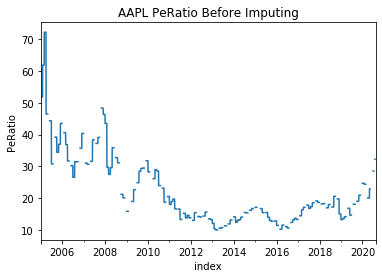

In [20]:
AAPL_valuation['PeRatio'].plot()
plt.title('AAPL PeRatio Before Imputing')
plt.ylabel('PeRatio')
plt.savefig('AAPL_PeRatio_Before_Imputing.png');

I have created a transformation that imputes the values using the Interpolate time method. This helps connect the dots. Below is an example after the imputing.

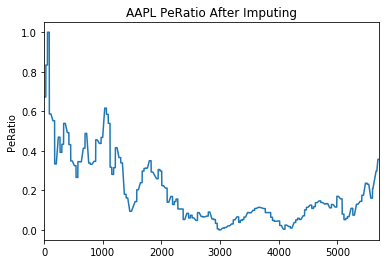

In [21]:
AAPL_scaled['PeRatio'].plot()
plt.title('AAPL PeRatio After Imputing')
plt.ylabel('PeRatio')
plt.savefig('AAPL_PeRatio_After_Imputing.png');

Here is another example of Microsoft. (First before and second after) 

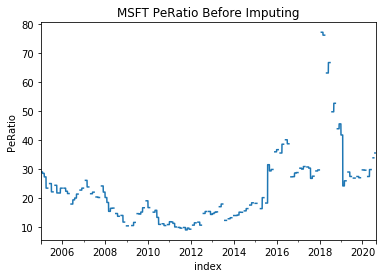

In [22]:
MSFT_valuation['PeRatio'].plot()
plt.title('MSFT PeRatio Before Imputing')
plt.ylabel('PeRatio')
plt.savefig('MSFT_PeRatio_Before_Imputing.png');

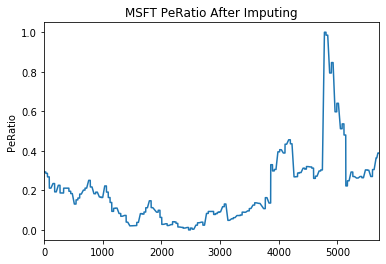

In [23]:
MSFT_scaled['PeRatio'].plot()
plt.title('MSFT PeRatio After Imputing')
plt.ylabel('PeRatio')
plt.savefig('MSFT_PeRatio_After_Imputing.png');

#### Heatmap Correlation

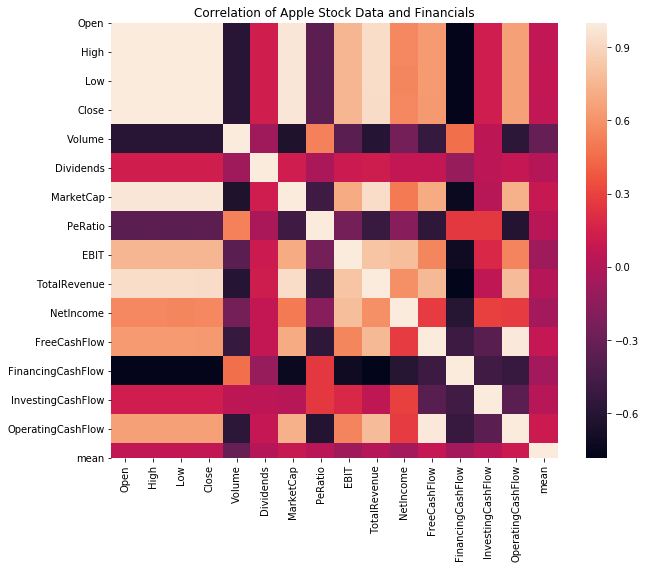

<Figure size 432x288 with 0 Axes>

In [24]:
data= AAPL_concat
fmapping, heatmapping = plt.subplots(figsize=(10, 8))
heatmapping= sns.heatmap(data.corr(), square=False)
heatmapping.set(title='Correlation of Apple Stock Data and Financials')
plt.show()
plt.savefig('Correlation_of_Apple_Stock_Data_and_Financials.png');

From this we can see that the stock data is highly correlated amongst each other as well as Total Revenue.

#### Looking at important dates and triggers of the market 2020

Dates:
- 2020-03-23: S&P hit their lowest point
- 2020-03-27: Stimulus package
- 2020-05-23: Memorial Day Weekend
- 2020-07-04: July 4th


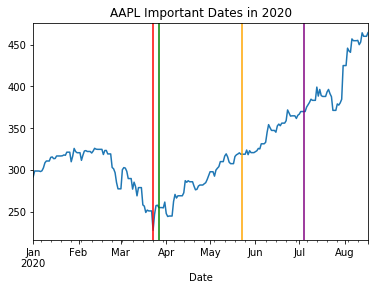

In [25]:
#APPLE
AAPL_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('AAPL Important Dates in 2020')
plt.savefig('AAPL_Important_Dates_in_2020.png');

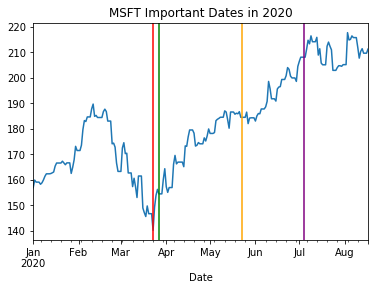

In [26]:
#Microsoft
MSFT_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('MSFT Important Dates in 2020')
plt.savefig('MSFT_Important_Dates_in_2020.png');

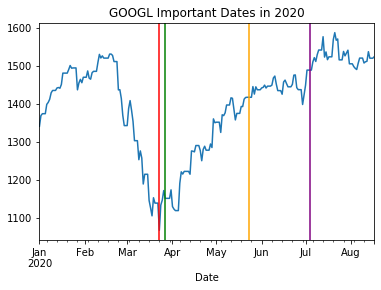

In [27]:
#GOOGLE
GOOGL_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('GOOGL Important Dates in 2020')
plt.savefig('GOOGL_Important_Dates_in_2020.png');

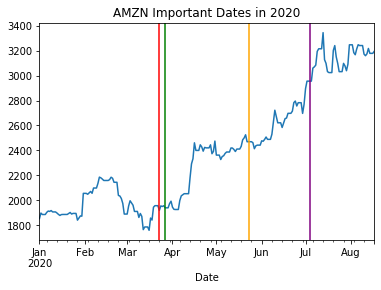

In [28]:
#Amazon 
AMZN_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('AMZN Important Dates in 2020')
plt.savefig('AMZN_Important_Dates_in_2020.png');

In [29]:
# #Facebook 
# FB_concat['High']['2020-01-01':].plot()
# plt.axvline('2020-03-23',color='red')
# plt.axvline('2020-03-27',color='green')
# plt.axvline('2020-07-04',color='purple')
# plt.axvline('2020-05-23',color='orange')
# plt.title('FB Important Dates in 2020')
# plt.savefig('FB_Important_Dates_in_2020.png');

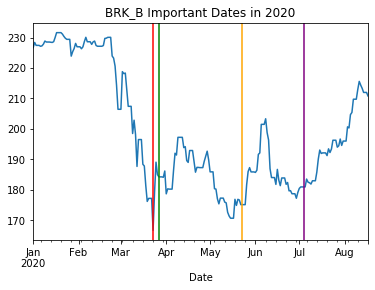

In [30]:
#Berkshire Hathaway
BRK_B_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('BRK_B Important Dates in 2020')
plt.savefig('BRK_B_Important_Dates_in_2020.png');

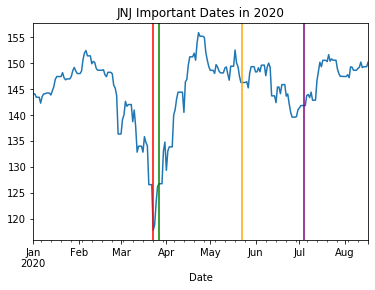

In [31]:
#Johnson and Johnson
JNJ_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('JNJ Important Dates in 2020');

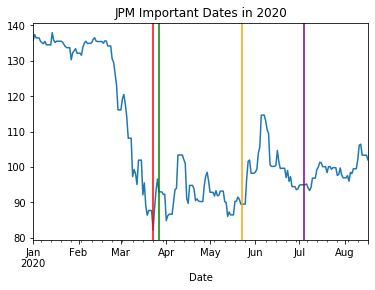

In [32]:
#JP. Morgan
JPM_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('JPM Important Dates in 2020')
plt.savefig('JPM_Important_Dates_in_2020.png');

In [33]:
# #Visa
# V_concat['High']['2020-01-01':].plot()
# plt.axvline('2020-03-23',color='red')
# plt.axvline('2020-03-27',color='green')
# plt.axvline('2020-07-04',color='purple')
# plt.axvline('2020-05-23',color='orange')
# plt.title('V Important Dates in 2020')
# plt.savefig('V_Important_Dates_in_2020.png');

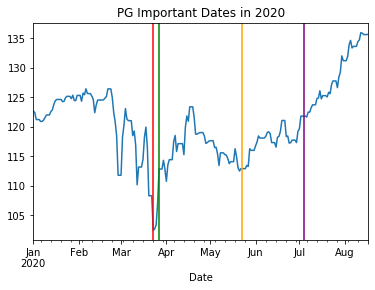

In [34]:
#Proctor and Gamble
PG_concat['High']['2020-01-01':].plot()
plt.axvline('2020-03-23',color='red')
plt.axvline('2020-03-27',color='green')
plt.axvline('2020-07-04',color='purple')
plt.axvline('2020-05-23',color='orange')
plt.title('PG Important Dates in 2020')
plt.savefig('PG_Important_Dates_in_2020.png');

## Univariate single layer Neural network linear regression 


In [35]:
#Function for plotting series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [36]:
#Sliding windows and data transformation
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [37]:
def univariate_single_layer_Neural_Network(company,splittime):
    time = np.arange(len(company), dtype="float32")
    series_close =company['Close']
    series_open =company['Open']
    x_train_close  = np.array(company['Close'][:splittime])
    x_train_open  = np.array(company['Open'][:splittime])
    time_train = time[:splittime]
    x_valid_close  = np.array(company['Close'][splittime:])
    x_valid_open  = np.array(company['Open'][splittime:])
    time_valid = time[splittime:]
    split_time =splittime
    window_size = 2
    batch_size = 34
    shuffle_buffer_size = len(company)
    split_time = splittime
    #Fitting model
    dataset_close = windowed_dataset(x_train_close, window_size, batch_size, shuffle_buffer_size)
    model_close = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_shape=[window_size])])
    # model_close.add(tf.keras.layers.Dropout(0.2))
    model_close.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
    model_close.fit(dataset_close,epochs=100,verbose=0)
    #Fitting model
    dataset_open = windowed_dataset(x_train_open, window_size, batch_size, shuffle_buffer_size)
    model_open = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_shape=[window_size])])
    model_open.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
    model_open.fit(dataset_close,epochs=100,verbose=0)
    #Forcasting
    forecast_close = []
    for time in range(len(series_close) - window_size):
        forecast_close.append(model_close.predict(np.array(series_close[time:time + window_size])[np.newaxis]))
    forecast_close = forecast_close[split_time-window_size:]
    results_close = np.array(forecast_close)[:, 0, 0]
    #Forcasting
    forecast_open = []
    for time in range(len(series_open) - window_size):
        forecast_open.append(model_open.predict(np.array(series_open[time:time + window_size])[np.newaxis]))
    forecast_open = forecast_open[split_time-window_size:]
    results_open = np.array(forecast_open)[:, 0, 0]
    predicted_open = pd.DataFrame(results_open)
    predicted_open.rename(columns={0:'open_predicted'},inplace=True)
    predicted_close = pd.DataFrame(results_close)
    predicted_close.rename(columns={0:'close_predicted'},inplace=True)
    valid_open = pd.DataFrame(x_valid_open)
    valid_open.rename(columns={0:'open_valid'},inplace=True)
    valid_close = pd.DataFrame(x_valid_close)
    valid_close.rename(columns={0:'close_valid'},inplace=True)
    open_close_concat = pd.concat([valid_open,valid_close,predicted_open,predicted_close],axis=1)
    Long = open_close_concat[open_close_concat['open_predicted']<open_close_concat['close_predicted']]
    Long['difference_valid'] = Long['close_valid']-Long['open_valid']
    Long['difference_predicted']=Long['close_predicted']-Long['open_predicted']
    open_close_concat['difference_valid'] = open_close_concat['close_valid']- open_close_concat['open_valid']
    open_close_concat['binary_valid']= open_close_concat['difference_valid'].map(lambda x: 1 if x>0 else 0)
    open_close_concat['difference_predicted'] = open_close_concat['close_predicted']- open_close_concat['open_predicted']
    open_close_concat['binary_predicted']= open_close_concat['difference_predicted'].map(lambda x: 1 if x>0 else 0)
    from sklearn.metrics import precision_score
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(open_close_concat['binary_valid'],open_close_concat['binary_predicted'])
    precision= precision_score(open_close_concat['binary_valid'],open_close_concat['binary_predicted'])
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(Long['difference_valid'],Long['difference_predicted']))
    return sum(Long['difference_valid']), accuracy, precision, rmse
    
    
    

In [38]:
sum_AAPL, accuracy_AAPL, precision_AAPL, RMSE_AAPL =univariate_single_layer_Neural_Network(AAPL,5478)
print('Accuracy:', accuracy_AAPL)
print('Precision:', precision_AAPL)
print('Total Profit',sum_AAPL)
print('RMSE',RMSE_AAPL )

Accuracy: 0.5739130434782609
Precision: 0.6230769230769231
Total Profit 158.95000000000005
RMSE 9.442168784396303


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
sum_MSFT, accuracy_MSFT, precision_MSFT, RMSE_MSFT =univariate_single_layer_Neural_Network(MSFT,5478)
print('Accuracy:', accuracy_MSFT)
print('Precision:', precision_MSFT)
print('Total Profit',sum_MSFT)
print('RMSE',RMSE_MSFT )

Accuracy: 0.5260869565217391
Precision: 0.5431034482758621
Total Profit 20.519999999999868
RMSE 8.446104581842743


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
sum_AMZN, accuracy_AMZN, precision_AMZN, RMSE_AMZN =univariate_single_layer_Neural_Network(AMZN,5478)
print('Accuracy:', accuracy_AMZN)
print('Precision:', precision_AMZN)
print('Total Profit',sum_AMZN)

Accuracy: 0.6173913043478261
Precision: 0.5925925925925926
Total Profit 608.2099999999998


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
sum_BRK_B, accuracy_BRK_B, precision_BRK_B, RMSE_BRK_B =univariate_single_layer_Neural_Network(BRK_B,5478)
print('Accuracy:', accuracy_BRK_B)
print('Precision:', precision_BRK_B)
print('Total Profit',sum_BRK_B)
print('RMSE',RMSE_BRK_B)

Accuracy: 0.6434782608695652
Precision: 0.6434782608695652
Total Profit 81.81000000000017
RMSE 3.5157596757083365


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [44]:
sum_GOOGL, accuracy_GOOGL, precision_GOOGL,RMSE_GOOGL =univariate_single_layer_Neural_Network(GOOGL,5478)
print('Accuracy:', accuracy_GOOGL)
print('Precision:', precision_GOOGL)
print('Total Profit',sum_GOOGL)
print('RMSE',RMSE_GOOGL)

Accuracy: 0.591304347826087
Precision: 0.6159420289855072
Total Profit 618.989999999998
RMSE 32.279125835959526


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
sum_JNJ, accuracy_JNJ, precision_JNJ, RMSE_JNJ =univariate_single_layer_Neural_Network(JNJ,5478)
print('Accuracy:', accuracy_JNJ)
print('Precision:', precision_JNJ)
print('Total Profit',sum_JNJ)
print('RMSE',RMSE_JNJ)

Accuracy: 0.5869565217391305
Precision: 0.5686274509803921
Total Profit 37.640000000000114
RMSE 3.167598818856859


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
sum_JPM, accuracy_JPM, precision_JPM, RMSE_JPM=univariate_single_layer_Neural_Network(JPM,5478)
print('Accuracy:', accuracy_JPM)
print('Precision:', precision_JPM)
print('Total Profit',sum_JPM)
print('RMSE',RMSE_JPM)

Accuracy: 0.5347826086956522
Precision: 0.43157894736842106
Total Profit 8.129999999999797
RMSE 4.130226651338521


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
sum_PG, accuracy_PG, precision_PG, RMSE_PG =univariate_single_layer_Neural_Network(PG,5478)
print('Accuracy:', accuracy_PG)
print('Precision:', precision_PG)
print('Total Profit',sum_PG)
print('RMSE',RMSE_PG)

Accuracy: 0.6043478260869565
Precision: 0.6541353383458647
Total Profit 69.74999999999982
RMSE 2.670334256090613


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
companies = [AAPL,MSFT,AMZN,PG,JNJ,JPM,BRK_B,GOOGL]

In [49]:
count_high=0
for i in companies:
    count_high+= max(i['High'])
count_high 

6274.8

In [50]:
summing=[sum_PG,sum_JPM,sum_JNJ,sum_GOOGL,sum_BRK_B,sum_AMZN,sum_MSFT,sum_AAPL]
sums=0
for i in summing:
    sums+= i
sums 


1603.9999999999975

In [51]:
percent = (sums/count_high)*100

In [52]:
print('If you put in', round(count_high,2), 'dollars you will have a return of', round(sums,2),', which is a',  round(percent,2),'% return in 2020 so far.')

If you put in 6274.8 dollars you will have a return of 1604.0 , which is a 25.56 % return in 2020 so far.


# Top 5 volitile stocks Univariate Single NN

In [53]:
#Top 5 volitile stocks
UBX = yfinance_import('UBX').resample('D').ffill()['2018-05-03':]
LODE = yfinance_import('LODE').resample('D').ffill()['2010-07-21':]
CLUB= yfinance_import('CLUB').resample('D').ffill()['2006-06-02':]
IDXG= yfinance_import('IDXG').resample('D').ffill()['2005-01-01':]
KGJI = yfinance_import('KGJI').resample('D').ffill()['2005-01-01':]

In [55]:
sum_LODE, accuracy_LODE, precision_LODE, RMSE_LODE =univariate_single_layer_Neural_Network(LODE, 3451)
print('Accuracy:', accuracy_LODE)
print('Precision:', precision_LODE)
print('Total Profit',sum_LODE)
print('RMSE',RMSE_LODE)

Accuracy: 0.5695652173913044
Precision: 0.4461538461538462
Total Profit 0.2800000000000003
RMSE 0.08189612134038092


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
sum_UBX, accuracy_UBX, precision_UBX, RMSE_UBX =univariate_single_layer_Neural_Network(UBX,608)
print('Accuracy:', accuracy_UBX)
print('Precision:', precision_UBX)
print('Total Profit',sum_UBX)
print('RMSE',RMSE_UBX)

Accuracy: 0.45652173913043476
Precision: 0.45652173913043476
Total Profit -6.734999999999999
RMSE 7.586273500009842


In [57]:
sum_CLUB, accuracy_CLUB, precision_CLUB, RMSE_CLUB =univariate_single_layer_Neural_Network(CLUB,4961)
print('Accuracy:', accuracy_CLUB)
print('Precision:', precision_CLUB)
print('Total Profit',sum_CLUB)
print('RMSE',RMSE_CLUB)

Accuracy: 0.6
Precision: 0.4044943820224719
Total Profit 1.4700000000000029
RMSE 0.24535584487192208


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
sum_IDXG, accuracy_IDXG, precision_IDXG, RMSE_IDXG =univariate_single_layer_Neural_Network(IDXG,5478)
print('Accuracy:', accuracy_IDXG)
print('Precision:', precision_IDXG)
print('Total Profit',sum_IDXG)
print('RMSE',RMSE_IDXG)

Accuracy: 0.6521739130434783
Precision: 0.6095238095238096
Total Profit 8.299999999999997
RMSE 0.4031609601122602


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [61]:
sum_KGJI, accuracy_KGJI, precision_KGJI, RMSE_KGJI =univariate_single_layer_Neural_Network(KGJI,5478)
print('Accuracy:', accuracy_KGJI)
print('Precision:', precision_KGJI)
print('Total Profit',sum_KGJI)
print('RMSE',RMSE_KGJI)

Accuracy: 0.6043478260869565
Precision: 0.4838709677419355
Total Profit 0.11999999999999994
RMSE 0.1959751561454384


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [62]:
summing=[sum_LODE,sum_UBX,sum_CLUB,sum_IDXG,sum_KGJI]
sums=0
for i in summing:
    sums+= i
sums 


3.4350000000000014

In [63]:
companying=[LODE,UBX,CLUB,IDXG,KGJI]

In [64]:
count_high=0
for i in companying:
    count_high+= max(i['High'])
count_high 

2412.2704

In [65]:
percent = (sums/count_high)*100

In [66]:
print('If you put in', round(count_high,2), 'dollars you will have a return of', round(sums,2),', which is a',  round(percent,2),'% return in 2020 so far.')

If you put in 2412.27 dollars you will have a return of 3.44 , which is a 0.14 % return in 2020 so far.


## Top 5 Hand Selected Stocks

In [67]:
TSLA = yfinance_import('TSLA').resample('D').ffill()['2005-01-01':]
ISRG = yfinance_import('ISRG').resample('D').ffill()['2005-01-01':]

In [68]:
sum_TSLA, accuracy_TSLA, precision_TSLA, RMSE_TSLA =univariate_single_layer_Neural_Network(TSLA,3473)
print('Accuracy:', accuracy_TSLA)
print('Precision:', precision_TSLA)
print('Total Profit',sum_TSLA)
print('RMSE',RMSE_TSLA)

Accuracy: 0.6130434782608696
Precision: 0.6095238095238096
Total Profit 424.0399999999993
RMSE 47.601468252651415


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [69]:
sum_ISRG, accuracy_ISRG, precision_ISRG, RMSE_ISRG =univariate_single_layer_Neural_Network(ISRG,5478)
print('Accuracy:', accuracy_ISRG)
print('Precision:', precision_ISRG)
print('Total Profit',sum_ISRG)
print('RMSE',RMSE_ISRG)

Accuracy: 0.6347826086956522
Precision: 0.6068376068376068
Total Profit 426.67000000000036
RMSE 11.5163907055924


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [70]:
sum_GOOGL, accuracy_GOOGL, precision_GOOGL, RMSE_GOOGL =univariate_single_layer_Neural_Network(GOOGL,5478)
print('Accuracy:', accuracy_GOOGL)
print('Precision:', precision_GOOGL)
print('Total Profit',sum_GOOGL)
print('RMSE',RMSE_GOOGL)


Accuracy: 0.6086956521739131
Precision: 0.6428571428571429
Total Profit 571.0899999999981
RMSE 28.787329232586703


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [71]:
sum_AMZN, accuracy_AMZN, precision_AMZN, RMSE_AMZN =univariate_single_layer_Neural_Network(AMZN,5478)
print('Accuracy:', accuracy_AMZN)
print('Precision:', precision_AMZN)
print('Total Profit',sum_AMZN)
print('RMSE',RMSE_AMZN)

Accuracy: 0.6173913043478261
Precision: 0.5877192982456141
Total Profit 576.9599999999994
RMSE 52.20002285563275


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [72]:
sum_AAPL, accuracy_AAPL, precision_AAPL, RMSE_AAPL =univariate_single_layer_Neural_Network(AAPL,5478)
print('Accuracy:', accuracy_AAPL)
print('Precision:', precision_AAPL)
print('Total Profit',sum_AAPL)
print('RMSE',RMSE_AAPL)


Accuracy: 0.5608695652173913
Precision: 0.6178861788617886
Total Profit 177.38999999999996
RMSE 17.247963662892566


/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [73]:
summing=[sum_TSLA,sum_ISRG,sum_GOOGL,sum_AMZN,sum_AAPL]
sums=0
for i in summing:
    sums+= i
sums 


2176.149999999997

In [74]:
companying=[AMZN, AAPL, GOOGL, TSLA, ISRG]

In [75]:
count_high=0
for i in companying:
    count_high+= max(i['High'])
count_high 

7945.549999999999

In [76]:
percent = (sums/count_high)*100

In [77]:
print('If you put in', round(count_high,2), 'dollars you will have a return of', round(sums,2),', which is a',  round(percent,2),'% return in 2020 so far.')

If you put in 7945.55 dollars you will have a return of 2176.15 , which is a 27.39 % return in 2020 so far.


## Univariate LSTM Time series model 

In [78]:
#Transforming dataset 
def creat_dataset(X,y,time_steps=1):
    Xs, ys =[],[]
    for i in range(len(X)-time_steps):
        v=X.iloc[i:(i+time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [79]:
def univariate_lstm_model(company,starttime,splittime):
    company2 = -(company - company['High'].max())/(company['High'].max()-company['Low'].min())
    x_train_close  = pd.DataFrame(company2['Close'][starttime:splittime])
    x_train_open  = pd.DataFrame(company2['Open'][starttime:splittime])
    x_valid_close  = pd.DataFrame(company2['Close'][splittime:])
    x_valid_open  = pd.DataFrame(company2['Open'][splittime:])
#     time_valid = time[splittime:]
    TIME_STEPS = 2
    X_train_close, y_train_close = creat_dataset(x_train_close, x_train_close['Close'], time_steps=TIME_STEPS)
    X_train_open, y_train_open = creat_dataset(x_train_open, x_train_open['Open'], time_steps=TIME_STEPS)
    X_valid_close, y_valid_close = creat_dataset(x_valid_close, x_valid_close['Close'], time_steps=TIME_STEPS)
    X_valid_open, y_valid_open = creat_dataset(x_valid_open, x_valid_open['Open'], time_steps=TIME_STEPS)
    #Modeling and predicting
    from tensorflow import keras
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=200,input_shape=(X_train_close.shape[1], X_train_close.shape[2])))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss='mse',optimizer='adam')
    history = model.fit(X_train_close, y_train_close, epochs = 100, batch_size=30,shuffle=False,verbose=0)
    y_pred_close=model.predict(X_valid_close)
    y_predicting_values = pd.DataFrame(y_pred_close.reshape(1,-1)).T
    y_test_values_close = pd.DataFrame(y_valid_close.reshape(1,-1)).T
    #Modeling and predicting
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=200,input_shape=(X_train_open.shape[1], X_train_open.shape[2])))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss='mse',optimizer='adam')
    history = model.fit(X_train_open, y_train_open, epochs = 100, batch_size=30,shuffle=False,verbose=0)
    y_pred_open=model.predict(X_valid_open)
    y_predicting_values_open = pd.DataFrame(y_pred_open.reshape(1,-1)).T
    y_test_values_open = pd.DataFrame(y_valid_open.reshape(1,-1)).T
    y_predicting_values.rename(columns={0:'close_predicted'},inplace=True)
    y_test_values_close.rename(columns={0:'close_valid'},inplace=True)
    y_predicting_values_open.rename(columns={0:'open_predicted'},inplace=True)
    y_test_values_open.rename(columns={0:'open_valid'},inplace=True)
    concat_all = pd.concat([y_predicting_values,y_predicting_values_open,y_test_values_close,y_test_values_open],axis=1)
    concat_all = -((concat_all * (company['High'].max()-company['Low'].min()))-company['High'].max())
    concat_all['difference_predicted'] = concat_all['close_predicted']-concat_all['open_predicted']
    concat_all['difference_valid'] = concat_all['close_valid']-concat_all['open_valid']
    concat_all['binary_predicted'] = concat_all['difference_predicted'].map(lambda x: 1 if x>0 else 0)
    concat_all['binary_valid'] = concat_all['difference_valid'].map(lambda x: 1 if x>0 else 0)
    from sklearn.metrics import precision_score
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(concat_all['binary_valid'],concat_all['binary_predicted'])
    precision = precision_score(concat_all['binary_valid'],concat_all['binary_predicted'])
    Long = concat_all[concat_all['binary_predicted']==1]
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(concat_all['difference_valid'],concat_all['difference_predicted']))
    count = 0
    for i in Long['difference_valid']:
        count+=i
    return count, accuracy, precision, rmse

In [80]:
sum_LSTM_AAPL, accuracy_LSTM_AAPL, precision_LSTM_AAPL, RMSE_LSTM_AAPL =univariate_lstm_model(AAPL,0,5478)
print('Accuracy:', accuracy_LSTM_AAPL)
print('Precision:', precision_LSTM_AAPL)
print('Total Profit',sum_LSTM_AAPL)
print('RMSE',RMSE_LSTM_AAPL)


Accuracy: 0.6140350877192983
Precision: 0.6265822784810127
Total Profit 223.20999999999995
RMSE 7.04999936699109


In [81]:
sum_LSTM_MSFT, accuracy_LSTM_MSFT, precision_LSTM_MSFT, RMSE_LSTM_MSFT =univariate_lstm_model(MSFT,0,5478)
print('Accuracy:', accuracy_LSTM_MSFT)
print('Precision:', precision_LSTM_MSFT)
print('Total Profit',sum_LSTM_MSFT)
print('RMSE',RMSE_LSTM_MSFT)



Accuracy: 0.5307017543859649
Precision: 0.5454545454545454
Total Profit 17.30999999999989
RMSE 4.065114834935975


In [82]:
sum_LSTM_JPM, accuracy_LSTM_JPM, precision_LSTM_JPM, RMSE_LSTM_JPM  =univariate_lstm_model(JPM,0,5478)
print('Accuracy:', accuracy_LSTM_JPM)
print('Precision:', precision_LSTM_JPM)
print('Total Profit',sum_LSTM_JPM)
print('RMSE',RMSE_LSTM_JPM)


Accuracy: 0.5350877192982456
Precision: 0.4351851851851852
Total Profit -3.2000000000003297
RMSE 2.5985915935137123


In [83]:
sum_LSTM_JNJ, accuracy_LSTM_JNJ, precision_LSTM_JNJ, RMSE_LSTM_JNJ  =univariate_lstm_model(JNJ,0,5478)
print('Accuracy:', accuracy_LSTM_JNJ)
print('Precision:', precision_LSTM_JNJ)
print('Total Profit',sum_LSTM_JNJ)
print('RMSE',RMSE_LSTM_JNJ)


Accuracy: 0.6622807017543859
Precision: 0.6470588235294118
Total Profit 54.77999999999999
RMSE 2.2040609784033407


In [84]:
sum_LSTM_PG, accuracy_LSTM_PG, precision_LSTM_PG, RMSE_LSTM_PG  =univariate_lstm_model(PG,0,5478)
print('Accuracy:', accuracy_LSTM_PG)
print('Precision:', precision_LSTM_PG)
print('Total Profit',sum_LSTM_PG)
print('RMSE',RMSE_LSTM_PG)


Accuracy: 0.5745614035087719
Precision: 0.6287878787878788
Total Profit 63.759999999999806
RMSE 2.139409076858197


In [85]:
sum_LSTM_GOOGL, accuracy_LSTM_GOOGL, precision_LSTM_GOOGL, RMSE_LSTM_GOOGL  =univariate_lstm_model(GOOGL,0,5478)
print('Accuracy:', accuracy_LSTM_GOOGL)
print('Precision:', precision_LSTM_GOOGL)
print('Total Profit',sum_LSTM_GOOGL)
print('RMSE',RMSE_LSTM_GOOGL)



Accuracy: 0.5833333333333334
Precision: 0.6198347107438017
Total Profit 583.1299999999983
RMSE 26.947238284818187


In [86]:
sum_LSTM_AMZN, accuracy_LSTM_AMZN, precision_LSTM_AMZN, RMSE_LSTM_AMZN =univariate_lstm_model(AMZN,0,5478)
print('Accuracy:', accuracy_LSTM_AMZN)
print('Precision:', precision_LSTM_AMZN)
print('Total Profit',sum_LSTM_AMZN)
print('RMSE',RMSE_LSTM_AMZN)


Accuracy: 0.5964912280701754
Precision: 0.6206896551724138
Total Profit 641.8300000000006
RMSE 72.10256751004891


In [87]:
sum_LSTM_BRK_B, accuracy_LSTM_BRK_B, precision_LSTM_BRK_B , RMSE_LSTM_BRK_B =univariate_lstm_model(BRK_B,0,5478)
print('Accuracy:', accuracy_LSTM_BRK_B)
print('Precision:', precision_LSTM_BRK_B)
print('Total Profit',sum_LSTM_BRK_B)
print('RMSE',RMSE_LSTM_BRK_B)


Accuracy: 0.6447368421052632
Precision: 0.6568627450980392
Total Profit 92.4300000000002
RMSE 3.030763264489496


In [88]:
summing=[sum_LSTM_PG,sum_LSTM_JPM,sum_LSTM_JNJ,sum_LSTM_GOOGL,sum_LSTM_BRK_B,sum_LSTM_AMZN,sum_LSTM_MSFT,sum_LSTM_AAPL]
sums=0
for i in summing:
    sums+= i
sums 


1673.2499999999986

In [89]:
percent = (sums/count_high)*100

In [90]:
print('If you put in', round(count_high,2), 'dollars you will have a return of', round(sums,2),', which is a',  round(percent,2),'% return in 2020 so far.')

If you put in 7945.55 dollars you will have a return of 1673.25 , which is a 21.06 % return in 2020 so far.


# Top 5 volitile stocks Univariate LSTM

In [91]:
sum_LSTM_LODE, accuracy_LSTM_LODE, precision_LSTM_LODE, RMSE_LSTM_LODE  =univariate_lstm_model(LODE,0,3451)
print('Accuracy:', accuracy_LSTM_LODE)
print('Precision:', precision_LSTM_LODE)
print('Total Profit',sum_LSTM_LODE)
print('RMSE',RMSE_LSTM_LODE)

Accuracy: 0.5877192982456141
Precision: 0.44
Total Profit 0.13000000000003809
RMSE 0.047360217445174276


In [92]:
sum_LSTM_UBX, accuracy_LSTM_UBX, precision_LSTM_UBX, RMSE_LSTM_UBX  =univariate_lstm_model(UBX,0,608)
print('Accuracy:', accuracy_LSTM_UBX)
print('Precision:', precision_LSTM_UBX)
print('Total Profit',sum_LSTM_UBX)
print('RMSE',RMSE_LSTM_UBX)

Accuracy: 0.5745614035087719
Precision: 0.5425531914893617
Total Profit -0.660000000000009
RMSE 0.3666638742378621


In [93]:
sum_LSTM_CLUB, accuracy_LSTM_CLUB, precision_LSTM_CLUB, RMSE_LSTM_CLUB  =univariate_lstm_model(CLUB,0,4961)
print('Accuracy:', accuracy_LSTM_CLUB)
print('Precision:', precision_LSTM_CLUB)
print('Total Profit',sum_LSTM_CLUB)
print('RMSE',RMSE_LSTM_CLUB)

Accuracy: 0.6754385964912281
Precision: 0.4864864864864865
Total Profit 1.9700000000000042
RMSE 0.12762893565977665


In [94]:
sum_LSTM_IDXG, accuracy_LSTM_IDXG, precision_LSTM_IDXG, RMSE_LSTM_IDXG  =univariate_lstm_model(IDXG,0,5478)
print('Accuracy:', accuracy_LSTM_IDXG)
print('Precision:', precision_LSTM_IDXG)
print('Total Profit',sum_LSTM_IDXG)
print('RMSE',RMSE_LSTM_IDXG)

Accuracy: 0.5175438596491229
Precision: 0.4816753926701571
Total Profit 1.5800000000049295
RMSE 0.4183627808987033


In [95]:
sum_LSTM_KGJI, accuracy_LSTM_KGJI, precision_LSTM_KGJI, RMSE_LSTM_KGJI  =univariate_lstm_model(KGJI,0,5478)
print('Accuracy:', accuracy_LSTM_KGJI)
print('Precision:', precision_LSTM_KGJI)
print('Total Profit',sum_LSTM_KGJI)
print('RMSE',RMSE_LSTM_KGJI)

Accuracy: 0.6271929824561403
Precision: 0.5172413793103449
Total Profit 0.2700000000000067
RMSE 0.07901774026382818


In [96]:
summing=[sum_LSTM_LODE,sum_LSTM_UBX,sum_LSTM_CLUB,sum_LSTM_IDXG,sum_LSTM_KGJI]
sums=0
for i in summing:
    sums+= i
sums 


3.2900000000049694

In [97]:
percent = (sums/count_high)*100

In [98]:
companying=[LODE,UBX,CLUB,IDXG,KGJI]

In [99]:
count_high=0
for i in companying:
    count_high+= max(i['High'])
count_high 

2412.2704

In [100]:
print('If you put in', round(count_high,2), 'dollars you will have a return of', round(sums,2),', which is a',  round(percent,2),'% return in 2020 so far.')

If you put in 2412.27 dollars you will have a return of 3.29 , which is a 0.04 % return in 2020 so far.


# Top 5 Hand selected stocks

In [101]:
sum_LSTM_TSLA, accuracy_LSTM_TSLA, precision_LSTM_TSLA, RMSE_LSTM_TSLA  =univariate_lstm_model(TSLA,0,3473)
print('Accuracy:', accuracy_LSTM_TSLA)
print('Precision:', precision_LSTM_TSLA)
print('Total Profit',sum_LSTM_TSLA)
print('RMSE',RMSE_LSTM_TSLA)

Accuracy: 0.5701754385964912
Precision: 0.55
Total Profit 395.1099999999981
RMSE 45.399145132861136


In [102]:
sum_LSTM_ISRG, accuracy_LSTM_ISRG, precision_LSTM_ISRG, RMSE_LSTM_ISRG  =univariate_lstm_model(ISRG,0,5478)
print('Accuracy:', accuracy_LSTM_ISRG)
print('Precision:', precision_LSTM_ISRG)
print('Total Profit',sum_LSTM_ISRG)
print('RMSE',RMSE_LSTM_ISRG)

Accuracy: 0.6096491228070176
Precision: 0.5871559633027523
Total Profit 407.11000000000024
RMSE 11.584868894695756


In [103]:
sum_LSTM_GOOGL, accuracy_LSTM_GOOGL, precision_LSTM_GOOGL, RMSE_LSTM_GOOGL  =univariate_lstm_model(GOOGL,0,5478)
print('Accuracy:', accuracy_LSTM_GOOGL)
print('Precision:', precision_LSTM_GOOGL)
print('Total Profit',sum_LSTM_GOOGL)
print('RMSE',RMSE_LSTM_GOOGL)


Accuracy: 0.5877192982456141
Precision: 0.625
Total Profit 585.8299999999983
RMSE 26.986099564969248


In [104]:
sum_LSTM_AMZN, accuracy_LSTM_AMZN, precision_LSTM_AMZN, RMSE_LSTM_AMZN  =univariate_lstm_model(AMZN,0,5478)
print('Accuracy:', accuracy_LSTM_AMZN)
print('Precision:', precision_LSTM_AMZN)
print('Total Profit',sum_LSTM_AMZN)
print('RMSE',RMSE_LSTM_AMZN)


Accuracy: 0.5307017543859649
Precision: 0.4972375690607735
Total Profit 110.7299999999982
RMSE 84.38600656279381


In [105]:
sum_LSTM_AAPL, accuracy_LSTM_AAPL, precision_LSTM_AAPL, RMSE_LSTM_AAPL  =univariate_lstm_model(AAPL,0,5478)
print('Accuracy:', accuracy_LSTM_AAPL)
print('Precision:', precision_LSTM_AAPL)
print('Total Profit',sum_LSTM_AAPL)
print('RMSE',RMSE_LSTM_AAPL)



Accuracy: 0.5921052631578947
Precision: 0.6277372262773723
Total Profit 209.84999999999994
RMSE 6.884233225163696


In [106]:
summing=[sum_LSTM_TSLA,sum_LSTM_ISRG,sum_LSTM_GOOGL,sum_LSTM_AMZN,sum_LSTM_AAPL]
sums=0
for i in summing:
    sums+= i
sums 


1708.6299999999947

In [107]:
percent = (sums/count_high)*100

In [108]:
companying=[AMZN, AAPL, GOOGL, TSLA, ISRG]

In [109]:
count_high=0
for i in companying:
    count_high+= max(i['High'])
count_high 

7945.549999999999

In [110]:
print('If you put in', round(count_high,2), 'dollars you will have a return of', round(sums,2),', which is a',  round(percent,2),'% return in 2020 so far.')

If you put in 7945.55 dollars you will have a return of 1708.63 , which is a 70.83 % return in 2020 so far.


## LSTM Multivariate

In [111]:
#Transforming dataset 
def creating_dataset(X,time_steps=1):
    Xs, ys =[],[]
    for i in range(len(X)-time_steps):
        v=X.iloc[i:(i+time_steps)].to_numpy()
        Xs.append(v)
        ys.append(X.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [113]:
# #Helping rename columns
# def column_names3(x): 
#     x.rename(columns={0:'Open_valid', 1:'High_valid', 2:'Low_valid', 3:'Close_valid', 4:'Volume_valid', 5:'Dividends_valid', 6:'MarketCap_valid',
#        7:'PeRatio_valid', 8:'EBIT_valid', 9:'TotalRevenue_valid', 10:'NetIncome_valid', 11:'FreeCashFlow_valid',
#        12:'FinancingCashFlow_valid', 13:'InvestingCashFlow_valid', 14:'OperatingCashFlow_valid'},inplace=True)
#     return x

In [114]:
# AAPL_scaled= AAPL_scaled[['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'MarketCap',
#        'PeRatio', 'EBIT', 'TotalRevenue', 'NetIncome', 'FreeCashFlow',
#        'FinancingCashFlow', 'InvestingCashFlow', 'OperatingCashFlow']]

In [115]:
# #Train Test Split

# scaled_train =AAPL_scaled[:5458]
# scaled_test = AAPL_scaled[5458:]
# from sklearn.metrics import precision_score

In [117]:
# def multivariate_LSTM(company_scaled, starttime,splittime,epoch):
#     company_scaled= company_scaled[['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'MarketCap',
#        'PeRatio', 'EBIT', 'TotalRevenue', 'NetIncome', 'FreeCashFlow',
#        'FinancingCashFlow', 'InvestingCashFlow', 'OperatingCashFlow']]
#     train =company_scaled[starttime:splittime]
#     test = company_scaled[splittime:]
#     x_train, y_train = creating_dataset(train)
#     x_test, y_test = creating_dataset(test)
#     from tensorflow import keras
#     model = keras.Sequential()
#     model.add(keras.layers.LSTM(units=len(train.columns),input_shape=(x_train.shape[1], x_train.shape[2])))
#     model.add(keras.layers.Dense(units=len(train.columns)))
#     model.compile(loss='mse',optimizer='adam')
#     history = model.fit(x_train, y_train, epochs = epoch, batch_size=len(train.columns),shuffle=False,verbose=0)
#     y_pred=model.predict(x_test)
#     y_predicting_values = column_names2(pd.DataFrame(y_pred.reshape(-len(test),len(train.columns))))
#     y_test_values = column_names3(pd.DataFrame(y_test.reshape(-len(test),len(train.columns))))
#     y_predicted_closing = pd.DataFrame(y_predicting_values['Close_predict'])
#     y_predicted_open = pd.DataFrame(y_predicting_values['Open_predict'])
#     y_tested_closing = pd.DataFrame(y_test_values['Close_valid'])
#     y_tested_open = pd.DataFrame(y_test_values['Open_valid'])
#     concat_predicted_test = pd.concat([y_predicted_closing,y_predicted_open,y_tested_closing,y_tested_open],axis=1)
#     concat_predicted_test = concat_predicted_test.pct_change()
#     concat_predicted_test['Predict_binary'] = concat_predicted_test['Close_predict'].map(lambda x: 1 if x>0 else 0)
#     concat_predicted_test['Valid_binary'] = concat_predicted_test['Close_valid'].map(lambda x: 1 if x>0 else 0)
#     stuff = concat_predicted_test[(concat_predicted_test['Predict_binary']==1)&(concat_predicted_test['Valid_binary']>=0)]
#     from sklearn.metrics import precision_score
#     from sklearn.metrics import accuracy_score
#     accuracy_scoring = accuracy_score(concat_predicted_test['Valid_binary'], concat_predicted_test['Predict_binary'])
#     precision = precision_score(concat_predicted_test['Valid_binary'],concat_predicted_test['Predict_binary'])
#     stuff['Closing_Valid_plus'] = stuff['Close_valid'].map(lambda x: x+1)
#     count = 1
#     for i in stuff['Closing_Valid_plus'][1:]:
#         count*=i
#     return (count-1), accuracy_scoring, precision
    
#     from sklearn.metrics import mean_squared_error
#     rmse = np.sqrt(mean_squared_error(concat_all['difference_valid'],concat_all['difference_predicted']))

In [ ]:
# #AAPL Scaled 
# count_AAPL, accuracy_scoring_AAPL = multivariate_LSTM(AAPL_scaled, 0,5478,110)
# print('ROI',count_AAPL)
# print('Accuracy Score', accuracy_scoring_AAPL)


In [ ]:
# count_AMZN, accuracy_scoring_AMZN = multivariate_LSTM(AMZN_scaled, 0,5478,110)
# print('ROI',count_AMZN)
# print('Accuracy Score', accuracy_scoring_AMZN)


In [ ]:
# #MSFT scaled
# count_MSFT, accuracy_scoring_MSFT = multivariate_LSTM(MSFT_scaled, 0,5478,200)
# print('ROI',count_MSFT)
# print('Accuracy Score', accuracy_scoring_MSFT)


In [ ]:
# #JNJ Scaled 
# count, accuracy_scoring = multivariate_LSTM(JNJ_scaled,0, 5478,110)
# print('ROI',count)
# print('Accuracy Score', accuracy_scoring)


In [ ]:
# #GOOGL Scaled 
# count, accuracy_scoring = multivariate_LSTM(GOOGL_scaled, 0,5478,110)
# print('ROI',count)
# print('Accuracy Score', accuracy_scoring)


In [ ]:
# #PG Scaled 
# count, accuracy_scoring = multivariate_LSTM(PG_scaled, 0,5478,110)
# print('ROI',count)
# print('Accuracy Score', accuracy_scoring)


In [ ]:
# #BRK_B Scaled 
# count, accuracy_scoring = multivariate_LSTM(BRK_B_scaled, 0,5478,110)
# print('ROI',count)
# print('Accuracy Score', accuracy_scoring)


In [ ]:
# #JPM Scaled 
# count, accuracy_scoring = multivariate_LSTM(JPM_scaled,3376 ,5478,110)
# print('ROI',count)
# print('Accuracy Score', accuracy_scoring)


In [376]:
def column_naming(x):
    x.rename(columns={0:'Open', 1:'High', 2:'Low', 3:'Close', 4:'Volume', 5:'MarketCap',
       6:'PeRatio', 7:'EBIT', 8:'TotalRevenue', 9:'NetIncome', 10:'FreeCashFlow',
       11:'FinancingCashFlow', 12:'InvestingCashFlow', 13:'OperatingCashFlow'},inplace=True)
    return x

In [377]:
def column_renaming_predicted(x):
    x.rename(columns={'Open':'Open_predicted','High':'High_predicted','Low':'Low_predicted','Close':'Close_predicted','Volume':'Volume_predicted','MarketCap':'MarketCap_predicted',
      'PeRatio':'PeRatio_predicted','EBIT':'EBIT_predicted','TotalRevenue':'TotalRevenue_predicted', 'NetIncome':'NetIncome_predicted', 'FreeCashFlow':'FreeCashFlow_predicted',
       'FinancingCashFlow':'FinancingCashFlow_predicted', 'InvestingCashFlow':'InvestingCashFlow_predicted', 'OperatingCashFlow':'OperatingCashFlow_predicted'},inplace=True)
    return x

In [378]:
def column_renaming_valid(x):
    x.rename(columns={'Open':'Open_valid','High':'High_valid','Low':'Low_valid','Close':'Close_valid','Volume':'Volume_valid','MarketCap':'MarketCap_valid',
      'PeRatio':'PeRatio_valid','EBIT':'EBIT_valid','TotalRevenue':'TotalRevenue_valid', 'NetIncome':'NetIncome_valid', 'FreeCashFlow':'FreeCashFlow_valid',
       'FinancingCashFlow':'FinancingCashFlow_valid', 'InvestingCashFlow':'InvestingCashFlow_valid', 'OperatingCashFlow':'OperatingCashFlow_valid'},inplace=True)
    return x

In [383]:
def Multivariate_LSTM(company,startime, splittime,EPOCH,time):
    company = company.drop(['mean','Dividends'],axis=1)
    company2 = -(company - company.max())/(company.max()-company.min())
    train = pd.DataFrame(company2[startime:splittime])
    test =  pd.DataFrame(company2[splittime:])
    TIME_STEPS = time
    x_train, y_train = creating_dataset(train,TIME_STEPS)
    x_test, y_test = creating_dataset(test,TIME_STEPS)
    from tensorflow import keras
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=len(train.columns),input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(keras.layers.Dense(units=len(train.columns)))
    model.compile(loss='mse',optimizer='adam')
    history = model.fit(x_train, y_train, epochs = EPOCH, batch_size=len(train.columns),shuffle=False,verbose=0)
    y_pred=model.predict(x_test)
    y_predicting_values = column_naming(pd.DataFrame(y_pred.reshape(-len(test),len(train.columns))))
    y_test_values = column_naming(pd.DataFrame(y_test.reshape(-len(test),len(train.columns))))
    y_predicting_values= -((y_predicting_values * (company.max()-company.min()))-company.max())
    y_test_values= -((y_test_values * (company.max()-company.min()))-company.max())
    y_predicting_values = column_renaming_predicted(y_predicting_values)
    y_test_values= column_renaming_valid(y_test_values)
    concat_all = pd.concat([y_predicting_values,y_test_values],axis=1)
    concat_all['difference_valid'] = concat_all['Close_valid'] - concat_all['Open_valid']
    concat_all['difference_predicted'] = concat_all['Close_predicted'] - concat_all['Open_predicted']
    concat_all['binary_valid'] = concat_all['difference_valid'].map(lambda x: 1 if x>0 else 0)
    concat_all['binary_predicted'] = concat_all['difference_predicted'].map(lambda x: 1 if x>0 else 0)
    Long = concat_all[concat_all['binary_predicted']==1]
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    accuracy = accuracy_score(concat_all['binary_valid'],concat_all['binary_predicted'])
    precision = precision_score(concat_all['binary_valid'],concat_all['binary_predicted'])
    count = sum(Long['difference_valid'])
    RMSE = np.sqrt(mean_squared_error(concat_all['difference_valid'],concat_all['difference_predicted']))
    return count, accuracy, precision, RMSE

In [407]:
count_GOOGL, accuracy_GOOGL, precision_GOOGL, RMSE_GOOGL = Multivariate_LSTM(GOOGL_concat,0,5478,120,2)
print('Accuracy:', accuracy_GOOGL)
print('Precision:', precision_GOOGL)
print('Total Profit',count_GOOGL)
print('RMSE',RMSE_GOOGL)

Accuracy: 0.45414847161572053
Precision: 0.5
Total Profit 63.01999999999998
RMSE 38.64231738251499


In [408]:
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Total Profit',count)
print('RMSE',RMSE)

Accuracy: 0.4692982456140351
Precision: 0.6666666666666666
Total Profit 66.6099999999999
RMSE 36.79163132306503


In [409]:
count_AAPL, accuracy_AAPL, precision_AAPL, RMSE_AAPL = Multivariate_LSTM(AAPL_concat,0,5478,120,2)
print('Accuracy:', accuracy_AAPL)
print('Precision:', precision_AAPL)
print('Total Profit',count_AAPL)
print('RMSE',RMSE_AAPL)

Accuracy: 0.4649122807017544
Precision: 0.5333333333333333
Total Profit 50.430000000000035
RMSE 14.256853927094442


In [410]:
count_AMZN, accuracy_AMZN, precision_AMZN, RMSE_AMZN = Multivariate_LSTM(AMZN_concat,0,5478,120,2)
print('Accuracy:', accuracy_AMZN)
print('Precision:', precision_AMZN)
print('Total Profit',count_AMZN)
print('RMSE',RMSE_AMZN)

Accuracy: 0.5219298245614035
Precision: 0.2857142857142857
Total Profit 39.12999999999943
RMSE 101.3475901629411


In [411]:
count_MSFT, accuracy_MSFT, precision_MSFT, RMSE_MSFT = Multivariate_LSTM(MSFT_concat,0,5478,120,3)
print('Accuracy:', accuracy_MSFT)
print('Precision:', precision_MSFT)
print('Total Profit',count_MSFT)
print('RMSE',RMSE_MSFT)

Accuracy: 0.5307017543859649
Precision: 0.5323741007194245
Total Profit 6.060000000000031
RMSE 8.105203496781114


In [416]:
count_JPM, accuracy_JPM, precision_JPM, RMSE_JPM = Multivariate_LSTM(JPM_concat,3376,5478,120,2)
print('Accuracy:', accuracy_JPM)
print('Precision:', precision_JPM)
print('Total Profit',count_JPM)
print('RMSE',RMSE_JPM)

Accuracy: 0.6052631578947368
Precision: 0.5263157894736842
Total Profit 7.419999999999959
RMSE 2.437298848057394


In [417]:
count_JNJ, accuracy_JNJ, precision_JNJ, RMSE_JNJ = Multivariate_LSTM(JNJ_concat,0,5478,120,2)
print('Accuracy:', accuracy_JNJ)
print('Precision:', precision_JNJ)
print('Total Profit',count_JNJ)
print('RMSE',RMSE_JNJ)

Accuracy: 0.40789473684210525
Precision: 0.35051546391752575
Total Profit -31.899999999999878
RMSE 2.251277701920127


In [418]:
count_PG, accuracy_PG, precision_PG, RMSE_PG = Multivariate_LSTM(PG_concat,0,5478,120,2)
print('Accuracy:', accuracy_PG)
print('Precision:', precision_PG)
print('Total Profit',count_PG)
print('RMSE',RMSE_PG)

Accuracy: 0.5833333333333334
Precision: 0.6323529411764706
Total Profit 63.33999999999982
RMSE 2.482202772887869


In [419]:
count_BRK_B, accuracy_BRK_B, precision_BRK_B, RMSE_BRK_B = Multivariate_LSTM(BRK_B_concat,0,5478,120,2)
print('Accuracy:', accuracy_BRK_B)
print('Precision:', precision_BRK_B)
print('Total Profit',count_BRK_B)
print('RMSE',RMSE_BRK_B)

Accuracy: 0.5
Precision: 0.0
Total Profit -0.2300000000000182
RMSE 3.3996281078543604


In [420]:
summing=[count_PG,count_JPM,count_JNJ,count_GOOGL,count_BRK_B,count_AMZN,count_MSFT,count_AAPL]
sums=0
for i in summing:
    sums+= i
sums 


197.26999999999936

In [421]:
companies = [AAPL,MSFT,AMZN,PG,JNJ,JPM,BRK_B,GOOGL]

In [422]:
count_high=0
for i in companies:
    count_high+= max(i['High'])
count_high 

6276.35

In [423]:
percent = (sums/count_high)*100

In [424]:
print('If you put in', round(count_high,2), 'dollars you will have a return of', round(sums,2),', which is a',  round(percent,2),'% return in 2020 so far.')

If you put in 6276.35 dollars you will have a return of 197.27 , which is a 3.14 % return in 2020 so far.
